# Descprition
This mini assignment explores sentiment analysis using an Amazon customer review dataset from Kaggle.

After performing basic exploratory data analysis (EDA), the notebook uses the VADER sentiment analyzer to classify reviews as positive, neutral, or negative based on their textual content. These predictions are then compared to the original user ratings (1–5 stars) to evaluate how accurately VADER reflects real customer satisfaction.

The analysis highlights how sentiment tools perform on real-world review data and discusses potential biases, such as VADER’s tendency to overestimate positivity in product-related texts.


OBS. In case the data wont read correct, here is the Kaggle URL https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data

# Packages and data import

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [52]:
df = pd.read_csv("/Users/nielsandersen/Desktop/Natural_Language_Processing_and_Nework_Analysis/Mini assignment/Amazon_data/Amazon_dataset_kaggle.csv")

cols = ['name', 'brand', 'categories', 'reviews.rating', 'reviews.title', 'reviews.text']
df = df[cols].dropna(subset=['reviews.text', 'reviews.rating'])

# Gør rating til heltal
df['reviews.rating'] = df['reviews.rating'].astype(int)

# Fjern dubletter
df.drop_duplicates(subset=['reviews.text'], inplace=True)

# Print status
print("Rows", len(df))
print("Average rating", round(df['reviews.rating'].mean(),2))


Rows 34626
Average rating 4.58


/var/folders/0g/w42qpyq17tl1kmydw0bc3x300000gn/T/ipykernel_51442/1377704147.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/nielsandersen/Desktop/Natural_Language_Processing_and_Nework_Analysis/Mini assignment/Amazon_data/Amazon_dataset_kaggle.csv")


## Note: 
Data collumn reduction done with a specific curiosity in and reviewed by LLM

# Data overview, Cleaning

In [53]:
df.head(10)

,name,brand,categories,reviews.rating,reviews.title,reviews.text
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Kindle,This product so far has not disappointed. My c...
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,very fast,great for beginner or experienced person. Boug...
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",4,Good!!!,I've had my Fire HD 8 two weeks now and I love...
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Fantastic Tablet for kids,I bought this for my grand daughter when she c...
5,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Just what we expected,This amazon fire 8 inch tablet is the perfect ...
6,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",4,great e-reader tablet,"Great for e-reading on the go, nice and light ..."
7,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Great for gifts,"I gave this as a Christmas gift to my inlaws, ..."
8,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Great for reading,Great as a device to read books. I like that i...
9,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5,Great and lightweight reader,I love ordering books and reading them with th...


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34626 entries, 0 to 34659
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            27867 non-null  object
 1   brand           34626 non-null  object
 2   categories      34626 non-null  object
 3   reviews.rating  34626 non-null  int64 
 4   reviews.title   34620 non-null  object
 5   reviews.text    34626 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.8+ MB


In [55]:
text_col  = "reviews.text"
label_col = "reviews.rating" 

# Quick sanity:
assert text_col in df.columns,  f"Mangler kolonne: {text_col}"
assert label_col in df.columns, f"Mangler kolonne: {label_col}"


In [56]:
df[text_col] = df[text_col].astype(str).str.strip()
df = df[df[text_col].str.len() > 0].copy()


if "char_len" not in df.columns:
    df["char_len"] = df[text_col].str.len()
if "word_len" not in df.columns:
    df["word_len"] = df[text_col].str.split().apply(len)

df[[text_col, "char_len", "word_len"]].head()



,reviews.text,char_len,word_len
0,This product so far has not disappointed. My c...,143,27
1,great for beginner or experienced person. Boug...,75,14
2,Inexpensive tablet for him to use and learn on...,131,26
3,I've had my Fire HD 8 two weeks now and I love...,593,117
4,I bought this for my grand daughter when she c...,613,117


# VADER score

In [57]:
try:
    sia = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download("vader_lexicon")
    sia = SentimentIntensityAnalyzer()

# Thresholds are kept as VADER's standard for bucketing 
def to_bucket(x: float) -> str:
    if x >= 0.05:
        return "positive"
    elif x <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_compound"] = df[text_col].apply(lambda s: sia.polarity_scores(s)["compound"])
df["vader_bucket"]   = df["vader_compound"].apply(to_bucket)

df[[text_col, "vader_compound", "vader_bucket"]].head()


,reviews.text,vader_compound,vader_bucket
0,This product so far has not disappointed. My c...,0.9194,positive
1,great for beginner or experienced person. Boug...,0.8934,positive
2,Inexpensive tablet for him to use and learn on...,0.4404,positive
3,I've had my Fire HD 8 two weeks now and I love...,0.9884,positive
4,I bought this for my grand daughter when she c...,0.7876,positive


In [58]:
cols = [c for c in [text_col, "vader_compound", "vader_bucket", "char_len", "word_len", label_col] if c in df.columns]
df[cols].describe(include="all")


,reviews.text,vader_compound,vader_bucket,char_len,word_len,reviews.rating
count,34626,34626.000000,34626,34626.000000,34626.000000,34626.000000
unique,34625,NaN,3,NaN,NaN,NaN
top,I needed a tablet to keep at the hospital duri...,NaN,positive,NaN,NaN,NaN
freq,2,NaN,31002,NaN,NaN,NaN
mean,NaN,0.625286,NaN,158.164645,30.243950,4.584561
std,NaN,0.360431,NaN,182.376505,34.031756,0.735660
min,NaN,-0.966600,NaN,3.000000,1.000000,1.000000
25%,NaN,0.510600,NaN,70.000000,13.000000,4.000000
50%,NaN,0.757900,NaN,106.000000,21.000000,5.000000
75%,NaN,0.872000,NaN,183.000000,35.000000,5.000000


In [59]:
df[cols].sample(5, random_state=42)


,reviews.text,vader_compound,vader_bucket,char_len,word_len,reviews.rating
21267,Purchased this as an upgrade to the first gene...,0.9607,positive,1551,271,4
21797,Bought this for my wife and she loves it defin...,0.8074,positive,60,12,5
20228,Bought this Kindle for our grandchild and he l...,0.8614,positive,123,22,5
27304,So fun and useful. We play with it and rely se...,0.8464,positive,65,14,5
30059,"Great for streaming, TV shows! Highly recommen...",0.8165,positive,61,9,5


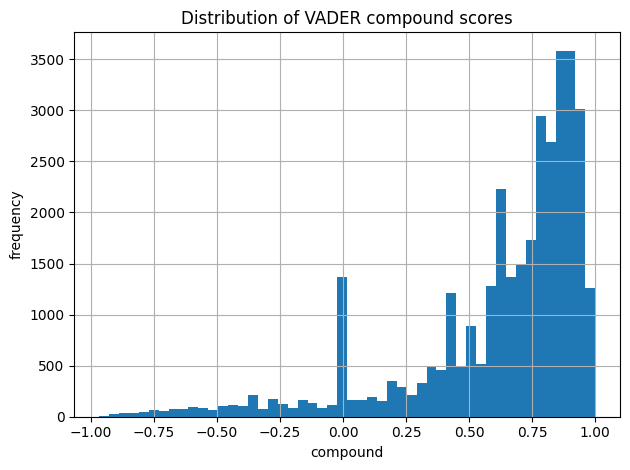

In [60]:
plt.figure()
df["vader_compound"].hist(bins=50)
plt.title("Distribution of VADER compound scores")
plt.xlabel("compound")
plt.ylabel("frequency")
plt.tight_layout()


The x-axis (“compound”) represents VADER’s sentiment score for each review, ranging from –1 (very negative) to +1 (very positive).

The y-axis (“frequency”) shows how many reviews fall within each score range.

Most reviews have compound scores between 0.5 and 1.0, meaning the vast majority of texts are clearly positive according to VADER.

In [61]:
ratings = pd.to_numeric(df[label_col], errors="coerce").astype("Int64")
mask = ratings.isin([1,2,3,4,5])
df_eval = df.loc[mask, [text_col, label_col, "vader_bucket"]].copy()
df_eval["rating_int"] = ratings[mask].astype(int)

# Map 1–2 -> negative, 3 -> neutral, 4–5 -> positive
def rating_to_bucket(r: int) -> str:
    if r in (1, 2): 
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df_eval["true_bucket"] = df_eval["rating_int"].map(rating_to_bucket)

# Metrics
labels = ["negative", "neutral", "positive"]
acc = accuracy_score(df_eval["true_bucket"], df_eval["vader_bucket"])
cm  = confusion_matrix(df_eval["true_bucket"], df_eval["vader_bucket"], labels=labels)

print(f"Accuracy: {acc:.2%}")
print("Confusion matrix (rows=true, cols=pred): [negative, neutral, positive]")
print(cm)


Accuracy: 86.78%
Confusion matrix (rows=true, cols=pred): [negative, neutral, positive]
[[  332   111   369]
 [  309   137  1053]
 [ 1443  1292 29580]]


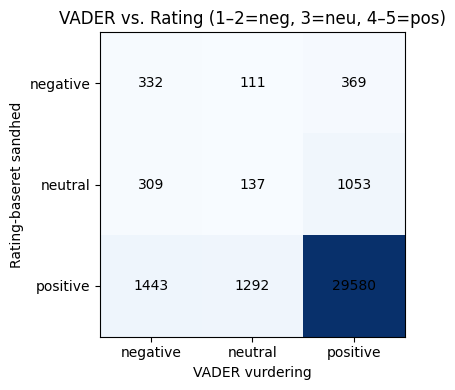

In [62]:
# 1. Create a simple overview of how often VADER predictions are incorrect
df_eval = df.copy()
df_eval["rating_group"] = df_eval[label_col].apply(lambda r: 
    "negative" if r in [1,2] else "neutral" if r == 3 else "positive"
)
df_eval["match"] = df_eval["rating_group"] == df_eval["vader_bucket"]

# 2. Count how many predictions are correct or incorrect
counts = df_eval.groupby(["rating_group", "vader_bucket"]).size().unstack(fill_value=0)

# 3. Creating a small heat-map visualization
plt.figure(figsize=(5,4))
plt.imshow(counts, cmap="Blues")
plt.xticks(ticks=range(len(counts.columns)), labels=counts.columns)
plt.yticks(ticks=range(len(counts.index)), labels=counts.index)
plt.xlabel("VADER vurdering")
plt.ylabel("Rating-baseret sandhed")
plt.title("VADER vs. Rating (1–2=neg, 3=neu, 4–5=pos)")


for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        plt.text(j, i, counts.iloc[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


# Result
The analysis shows that while VADER achieves a seemingly high overall accuracy of 86.78%, this result is largely driven by the strong class imbalance in the dataset, where most reviews are positive. With only 4.577 observations determined as not accurate.

VADER performs well on positive reviews but struggles to correctly identify neutral and negative sentiments, which are often misclassified as positive. This indicates that VADER’s default thresholds are too narrow for product review data, leading to an overestimation of positivity. Adjusting the neutral range or using a model fine-tuned on domain-specific data would likely yield a more balanced and reliable sentiment classification.